In [11]:
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from pre_processors.EdgeDetector import EdgeDetector
from pre_processors.GrabCut import GrabCut

In [12]:
image = cv2.imread('assets/QalamChi.jpg')

grab = GrabCut()
grab_cut = grab(image)

edge = EdgeDetector()
edges = edge(grab_cut)

In [13]:
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
cnt_img = image.copy()
cv2.drawContours(cnt_img, [largest_contour], 0, 255, 3)

array([[[ 46,  51,  49],
        [ 45,  50,  48],
        [ 46,  51,  49],
        ...,
        [180, 181, 179],
        [174, 175, 173],
        [176, 177, 175]],

       [[ 47,  52,  50],
        [ 46,  51,  49],
        [ 46,  51,  49],
        ...,
        [178, 179, 177],
        [173, 174, 172],
        [175, 176, 174]],

       [[ 48,  53,  51],
        [ 47,  52,  50],
        [ 47,  52,  50],
        ...,
        [183, 184, 182],
        [180, 181, 179],
        [183, 184, 182]],

       ...,

       [[ 31,  26,  17],
        [ 29,  24,  15],
        [ 28,  23,  14],
        ...,
        [ 60,  83,  91],
        [ 56,  81,  91],
        [ 57,  82,  92]],

       [[ 31,  26,  17],
        [ 29,  24,  15],
        [ 28,  23,  14],
        ...,
        [ 58,  81,  89],
        [ 53,  78,  88],
        [ 55,  80,  90]],

       [[ 31,  26,  17],
        [ 29,  24,  15],
        [ 27,  22,  13],
        ...,
        [ 57,  80,  88],
        [ 54,  79,  89],
        [ 58,  83,  93]]

In [14]:
epsilon = 0.002 * cv2.arcLength(largest_contour, True)
corners = cv2.approxPolyDP(largest_contour, epsilon, True)

In [15]:
lines = cv2.HoughLines(edges, 1, np.pi / 180, 150)

k = 3000

merged_lines = []
rho_threshold = 20
theta_threshold = np.pi / 36
for line in lines:
    rho, theta = line[0]
    matched = False
    for i, (avg_rho, avg_theta) in enumerate(merged_lines):
        # Check if the current line is similar to an existing cluster
        if abs(rho - avg_rho) < rho_threshold and abs(theta - avg_theta) < theta_threshold:
            # Update the cluster with the average values
            merged_lines[i] = ((avg_rho + rho) / 2, (avg_theta + theta) / 2)
            matched = True
            break
    if not matched:
        merged_lines.append((rho, theta))

In [16]:
intersections = []
for i in range(len(lines)):
    for j in range(i + 1, len(lines)):
        rho1, theta1 = lines[i][0]  # Unpack properly
        rho2, theta2 = lines[j][0]  # Unpack properly

        # Line parameters
        a1, b1 = np.cos(theta1), np.sin(theta1)
        a2, b2 = np.cos(theta2), np.sin(theta2)

        # Determinant
        determinant = a1 * b2 - a2 * b1
        if abs(determinant) < 1e-10:
            # Lines are parallel or coincident
            continue

        # Solve for intersection
        x = (b2 * rho1 - b1 * rho2) / determinant
        y = (a1 * rho2 - a2 * rho1) / determinant
        intersections.append((int(x), int(y)))


In [17]:

filtered_points = [
    point for point in intersections
    if 0 <= point[0] < image.shape[1] and 0 <= point[1] < image.shape[0]
]

points = np.array(filtered_points)
kmeans = KMeans(n_clusters=4, random_state=0).fit(points)
clusters = kmeans.cluster_centers_
sorted_clusters = sorted(
    clusters,
    key=lambda p: (p[0] + p[1], -p[0] + p[1], -p[0] - p[1], p[0] - p[1])
)

new_corners = [tuple(map(int, corner)) for corner in sorted_clusters]

for i, corner in enumerate(corners):
    print(f"Corner {i}: {corner}, Flattened: {corner.ravel()}")


Corner 0: [[ 46 307]], Flattened: [ 46 307]
Corner 1: [[105 832]], Flattened: [105 832]
Corner 2: [[595 781]], Flattened: [595 781]
Corner 3: [[423 321]], Flattened: [423 321]
Corner 4: [[395 306]], Flattened: [395 306]
Corner 5: [[ 64 291]], Flattened: [ 64 291]


In [18]:
# Step 1: Ensure a convex hull of the contour
hull = cv2.convexHull(largest_contour)

# Step 2: Approximate the polygon again (epsilon controls approximation accuracy)
epsilon = 0.02 * cv2.arcLength(hull, True)
corners = cv2.approxPolyDP(hull, epsilon, True)

# If more than 4 corners are detected, refine the selection
if len(corners) > 4:
    # Step 3: Calculate the centroid of the shape
    moments = cv2.moments(corners)
    cx = int(moments['m10'] / moments['m00'])
    cy = int(moments['m01'] / moments['m00'])
    center = (cx, cy)

    # Step 4: Sort corners by their distance to the center
    distances = [(corner, cv2.norm(corner[0] - center)) for corner in corners]
    distances.sort(key=lambda x: x[1], reverse=True)  # Sort by farthest points first
    corners = [corner[0] for corner in distances[:4]]  # Keep only the 4 farthest points

# Step 5: Order the corners (optional, for consistency)
# Use a sorting function to order corners as top-left, top-right, bottom-left, bottom-right
def order_points(points_c):
    points_c = sorted(points_c, key=lambda p: (p[0][1], p[0][0]))  # Sort by y, then x
    top_two = sorted(points_c[:2], key=lambda p: p[0][0])  # Top-left, top-right
    bottom_two = sorted(points_c[2:], key=lambda p: p[0][0])  # Bottom-left, bottom-right
    return top_two + bottom_two

ordered_corners = order_points(corners)


492.64694 725.31165
1.9076628661028543


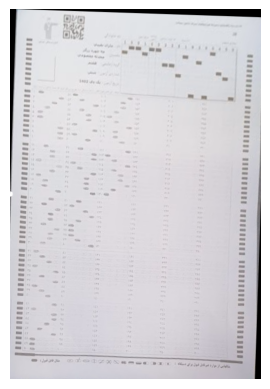

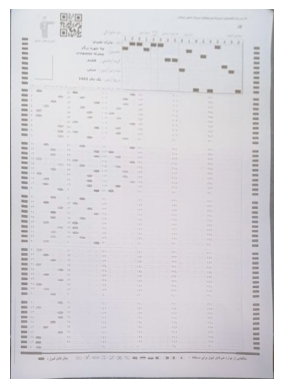

In [52]:
def order_points(points):
    points = sorted(points, key=lambda p: (p[1], p[0]))  # Sort by y, then x
    top_two = sorted(points[:2], key=lambda p: p[0])  # Top-left, top-right
    bottom_two = sorted(points[2:], key=lambda p: p[0])  # Bottom-left, bottom-right
    return np.array(top_two + bottom_two, dtype="float32")

def calculate_skew_angle(point1, point2):
    # Calculate the slope
    delta_y = point2[1] - point1[1]
    delta_x = point2[0] - point1[0]
    angle = math.degrees(math.atan2(delta_y, delta_x))  # Angle in degrees
    return angle

# Assume `corners` contains detected points
src_points = order_points([corner[0] for corner in corners])  # Extract coordinates

# Define the destination points for a rectangular output
width = max(np.linalg.norm(src_points[2] - src_points[3]), np.linalg.norm(src_points[1] - src_points[0]))
height = max(np.linalg.norm(src_points[1] - src_points[2]), np.linalg.norm(src_points[0] - src_points[3]))
print(width, height)
dst_points = np.array([
    [0, 0],          # Top-left
    [width, 0],  # Top-right
    [0, height], # Bottom-left
    [width, height]  # Bottom-right
], dtype="float32")

# Compute the perspective transformation matrix
matrix = cv2.getPerspectiveTransform(src_points, dst_points)

# Apply the perspective warp
warped_image = cv2.warpPerspective(image, matrix, (int(width), int(height)))

# Calculate skew angles
top_angle = calculate_skew_angle(src_points[0], src_points[1])  # Top edge
bottom_angle = calculate_skew_angle(src_points[2], src_points[3])  # Bottom edge
# Deskew the image by rotating based on average skew
average_skew = abs((top_angle + bottom_angle) / 2)
print(average_skew)
center = (0, warped_image.shape[0] // 2)
cv2.circle(warped_image, center, 5, (255, 255, 255), cv2.FILLED)
rotation_matrix = cv2.getRotationMatrix2D(center, -average_skew, 1.0)
# Rotate the warped image to deskew
deskewed_image = cv2.warpAffine(warped_image, rotation_matrix, (warped_image.shape[1], warped_image.shape[0]))

# Display the deskewed image
plt.imshow(deskewed_image, cmap='gray')
plt.axis("off")
plt.show()
scan = cv2.imread('output/QalamChi.jpg')
plt.imshow(scan)
plt.axis("off")
plt.show()